In [39]:
!pip install -r requirements.txt
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 53.5 MB/s eta 0:00:0000:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from unidecode import unidecode
import zipfile
import random
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset

from src.features.functions_preprocessing import *
from src.models.rnn_encoder_decoder import *
from src.models.transformer import *

In [41]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


# **Kaggle dataset**

In [42]:
!kaggle datasets download -d sbhatti/news-summarization

Dataset URL: https://www.kaggle.com/datasets/sbhatti/news-summarization
License(s): CC0-1.0
news-summarization.zip: Skipping, found more recently modified local copy (use --force to force download)


In [43]:
with zipfile.ZipFile("news-summarization.zip", "r") as zip_ref:
    zip_ref.extractall("news-summarization")

In [44]:
news_data = pd.read_csv("news-summarization/data.csv")

In [45]:
news_data.head()

,Unnamed: 0,ID,Content,Summary,Dataset
0,0,f49ee725a0360aa6881ed1f7999cc531885dd06a,New York police are concerned drones could bec...,Police have investigated criminals who have ri...,CNN/Daily Mail
1,1,808fe317a53fbd3130c9b7563341a7eea6d15e94,By . Ryan Lipman . Perhaps Australian porn sta...,Porn star Angela White secretly filmed sex act...,CNN/Daily Mail
2,2,98fd67bd343e58bc4e275bbb5a4ea454ec827c0d,"This was, Sergio Garcia conceded, much like be...",American draws inspiration from fellow country...,CNN/Daily Mail
3,3,e12b5bd7056287049d9ec98e41dbb287bd19a981,An Ebola outbreak that began in Guinea four mo...,World Health Organisation: 635 infections and ...,CNN/Daily Mail
4,4,b83e8bcfcd51419849160e789b6658b21a9aedcd,By . Associated Press and Daily Mail Reporter ...,A sinkhole opened up at 5:15am this morning in...,CNN/Daily Mail


In [46]:
N = random.randint(1, len(news_data))

print(news_data["Content"][N])
print()
print(news_data["Summary"][N])

Beer, or at least one of its ingredients, could boost brain function, a new study has found. But a leisurely pint is unlikely to have any intellectual benefit, because a person would need to drink the equivalent of 3,520 pints (2,000 litres) a day to stand any chance of boosting their cognitive abilities. Researchers demonstrated that xanthohumol – a type of flavonoid found in hops and beer - improved cognitive function in young mice. Line them up: A new study has found that drinking beer could make people and animals smarter, but humans would have to drink 3,520 pints (2,000 litres) of beer to stand any chance of booting their cognitive abilities - which the scientist's don't recommend . Flavonoids are compounds found in plants that often give them their colour and scientists have been studying them in blueberries, dark chocolate and red wine to uncover any potential benefits that could help fight cancer and heart disease, for example. Scientists hope that xanthohumol could be used to

In [47]:
lengths_article = news_data["Content"].str.len()
lengths_article.describe()

count    8.704870e+05
mean     4.008553e+03
std      5.585502e+03
min      1.400000e+01
25%      2.052000e+03
50%      3.316000e+03
75%      4.958000e+03
max      2.921656e+06
Name: Content, dtype: float64

In [48]:
news_data = news_data[
    (lengths_article >= lengths_article.quantile(0.20))
    & (lengths_article <= lengths_article.quantile(0.80))
]

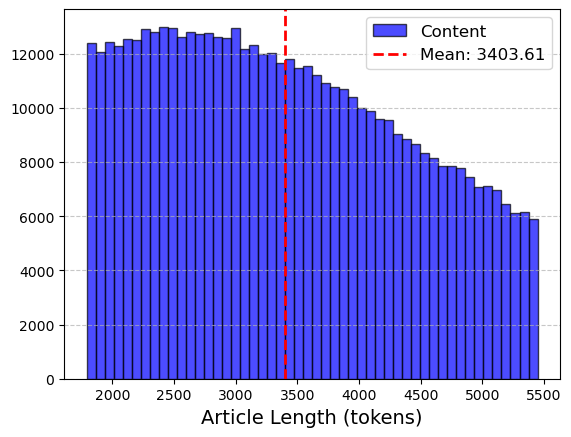

In [49]:
pd.DataFrame(news_data["Content"].str.len()).plot(
    kind="hist", bins=50, edgecolor="black", alpha=0.7, color="blue"
)
plt.axvline(
    news_data["Content"].str.len().mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f'Mean: {news_data["Content"].str.len().mean():.2f}',
)
plt.xlabel("Article Length (tokens)", fontsize=14)
plt.ylabel("")
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [50]:
lengths_summary = news_data["Summary"].str.len()
lengths_summary.describe()

count    522510.000000
mean        281.407389
std         192.308144
min           1.000000
25%         177.000000
50%         252.000000
75%         326.000000
max        8541.000000
Name: Summary, dtype: float64

In [51]:
news_data = news_data[
    (lengths_summary >= lengths_summary.quantile(0.20))
    & (lengths_summary <= lengths_summary.quantile(0.80))
]

In [52]:
news_data["Summary"].str.len().describe()

count    314019.000000
mean        251.663078
std          52.020129
min         151.000000
25%         211.000000
50%         252.000000
75%         294.000000
max         347.000000
Name: Summary, dtype: float64

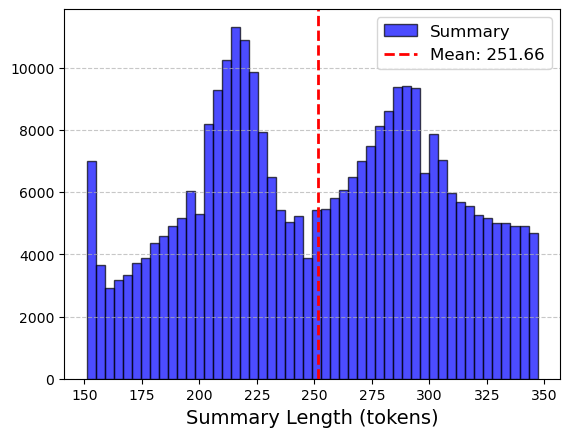

In [53]:
news_data["Summary"].str.len().plot(
    kind="hist", bins=50, edgecolor="black", alpha=0.7, color="blue"
)
plt.axvline(
    news_data["Summary"].str.len().mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f'Mean: {news_data["Summary"].str.len().mean():.2f}',
)
plt.xlabel("Summary Length (tokens)", fontsize=14)
plt.ylabel("")
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [54]:
len(news_data)

314019

In [55]:
# news_data["Content"] = news_data["Content"].apply(preprocess_article)
# news_data["Summary"] = news_data["Summary"].apply(preprocess_summary)

In [56]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [57]:
train_data = news_data[:5000]
test_data = news_data[5000:6000]

In [58]:
tokenized_articles = tokenizer(
    list(train_data["Content"]),
    truncation=True,
    padding="max_length",
    return_tensors="pt",
    max_length=512,
)["input_ids"].long()

tokenized_summaries = tokenizer(
    list(train_data["Summary"]),
    truncation=True,
    padding="max_length",
    return_tensors="pt",
    max_length=512,
)["input_ids"]

tokenized_summaries = torch.cat(
    [torch.zeros(tokenized_summaries.size(0), 1), tokenized_summaries], dim=1
).long()

article_ids = tokenized_articles.long()
summary_ids = tokenized_summaries.long()

In [63]:
batch_size = 10

dataset = TensorDataset(tokenized_articles, tokenized_summaries)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# **RNN**

# **Transformer**

In [33]:
model_transformer = Transformer(
    pad_idx=0,
    voc_size=tokenizer.vocab_size,
    hidden_size=128,
    n_head=8,
    max_len=512,
    dec_max_len=512,
    ffn_hidden=128,
    n_layers=3,
)

In [35]:
num_epochs = 10

loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.Adam(model_transformer.parameters(), lr=5e-4)
model = model_transformer.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(dataloader):
        input_batch, summary_batch = batch
        input_batch = input_batch.to(device)
        summary_batch = summary_batch.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_batch.long(), summary_batch[:, :-1])
        summary_batch = summary_batch[:, 1:]
        # Compute loss
        loss = loss_fn(
            outputs.reshape(-1, outputs.shape[-1]), summary_batch.reshape(-1)
        )
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        if step % 1000 == 0:
            print("Step-{}, Loss-{}".format(step, loss.item()))

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(dataloader)

    # Print the average loss
    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

Step-0, Loss-8.38060474395752
Epoch 1/5 - Average Loss: 7.0814
Step-0, Loss-6.569347858428955
Epoch 2/5 - Average Loss: 6.5378
Step-0, Loss-6.09676456451416
Epoch 3/5 - Average Loss: 6.2023
Step-0, Loss-6.078734874725342
Epoch 4/5 - Average Loss: 5.9007
Step-0, Loss-5.678478240966797
Epoch 5/5 - Average Loss: 5.6246


# **BERT model**

In [59]:
from transformers import BertTokenizer, BertModel, BertConfig


class UniLMTokenizer(BertTokenizer):
    def __init__(self, vocab_file, do_lower_case=True):
        super().__init__(vocab_file=vocab_file, do_lower_case=do_lower_case)


class UniLMModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased", config=config)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        logits = self.lm_head(sequence_output)
        return logits

In [60]:
config = BertConfig(
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_act="gelu",
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=512,
    vocab_size=tokenizer.vocab_size,
)

In [71]:
batch_size = 1

dataset = TensorDataset(tokenized_articles, tokenized_summaries[:, 1:])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [72]:
model = UniLMModel(config)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
model.to(device)

num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(dataloader):

        input_batch, summary_batch = batch
        input_batch = input_batch.to(device)
        summary_batch = summary_batch.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_batch, attention_mask=input_batch.ne(0))

        print(outputs.shape)
        print(summary_batch.shape)
        # Compute loss
        loss = loss_fn(outputs.view(-1, outputs.shape[-1]), summary_batch.view(-1))
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        if step % 100 == 0:
            print("Step-{}, Loss-{}".format(step, loss.item()))

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(dataloader)

    # Print the average loss
    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 90.00 MiB. GPU 0 has a total capacity of 14.53 GiB of which 4.00 MiB is free. Process 1564810 has 14.52 GiB memory in use. Of the allocated memory 14.32 GiB is allocated by PyTorch, and 125.84 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)